In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
#!pip install chromadb
#!pip install sentence-transformers
#!pip install langchain openai

In [85]:
import matplotlib.pyplot as plt

In [86]:
import os, sys
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.chroma as chom

## Naive Retriever

In [87]:
file_path = '../data/RobinsonAdvisory.pdf'
pdftexts = chom.pdf_reader(file_path)
pdftexts[0]

'ADVISORY SERVICES AGREEMENT \n \nThis Advisory Services Agreement is entered into as of June 15th, 2023 (the “Effective Date ”), by and \nbetween Cloud Investments Ltd., ID 51-426526-3, an Israeli company (the " Company "), and Mr. Jack \nRobinson, Passport Number 780055578, residing at 1 Rabin st, Tel Aviv, Israel, Email: \njackrobinson@gmail.com ("Advisor "). \n \nWhereas, Advisor has expertise and/or knowledge and/or relationships, which are relevant to the \nCompany ’s business and the Company has asked Advisor to provide it with certain Advisory \nservices, as described in this Agreement; and \nWhereas,  Advisor has agreed to provide the Company with such services, subject to the terms set forth \nin this Agreement. \n \nNOW THEREFORE THE PARTIES AGREE AS FOLLOWS: \n \n1. Services:   \n1.1 Advisor shall provide to the Company, as an independent contractor, software development \nservices, and / or any other services as agreed by the parties from time to time (the “Services ”). \n

In [88]:
character_split_texts = chom.text_splitter_chunks(pdftexts)
# print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")


Total chunks: 17


In [89]:
token_split_texts = chom.sentence_transfomer_textsplitter(character_split_texts)
# print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")


Total chunks: 17


In [90]:
from langchain.embeddings.openai import OpenAIEmbeddings
embed_model = OpenAIEmbeddings(model="text-embedding-ada-002")

embedding_fun = []
embedded_document = embed_model.embed_documents(token_split_texts)
embedding_fun.append(embedded_document)

In [91]:
embedding_function = chom.embedding(token_split_texts)
# print(embedding_function([token_split_texts[10]]))

In [92]:
import chromadb
def connect_with_chromadb(embedding_function, token_split_texts):
    chroma_client = chromadb.Client()
    chroma_collection = chroma_client.create_collection("microsoft_annual_report_l22", embedding_function=embedding_function)

    ids = [str(i) for i in range(len(token_split_texts))]

    chroma_collection.add(ids=ids, documents=token_split_texts)
    chroma_collection.count()
    return chroma_collection

In [93]:
chroma_collection = connect_with_chromadb(embedding_function, token_split_texts)
# chroma_collection.count()

In [94]:
query = "What are the payments to the Advisor under the Agreement?"
retrieved_documents = chom.vectordb_answer_question(query, chroma_collection)
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The payments to the Advisor under the Agreement consist of salary payments and 40% for statutory rights and benefits, with potential deductions for any amounts due, but may change in case of an employer-employee relationship determination.


# UMAP

In [95]:
# !pip install umap-learn

In [96]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [97]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [98]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 17/17 [00:10<00:00,  1.64it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

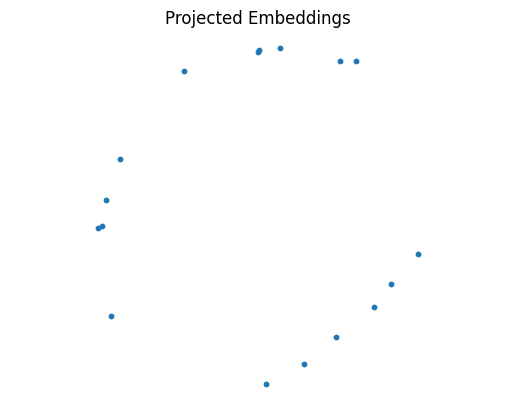

In [99]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

# Relevancy and Distraction

In [100]:
query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

providing the company a prompt written notice and subject to promptl y cooperate with the company in seeking a protective order. 3. safeguard : the advisor shall safeguard the confidential information, keep it in strict confidence and shall not disclose it to any third party without the prior written consent of the company. 4. ip : any work product, upon creation, shall be fully and exclusivel y owned by the company. the advisor, immediately upon company ’ s request, shall sign any document and / or perform any action neede d to formalize such ownership. the advisor shall not obtain any righ ts in the work product, including moral rights and / or rights for royalties or ot her consideration under any applicable law ( including section 134 of the israeli patent law – 1967 if applicable ), and shall not be entitled to any compe nsation with respect to the services, which was not specifically agreed, in writing, between the advisor and the comp any.

7. third parties : the advisor represe

In [101]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

Sellers are responsible for breach of representations and warranties if they fail to provide prompt written notices and cooperate to seek protective orders as per agreement terms.


In [102]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

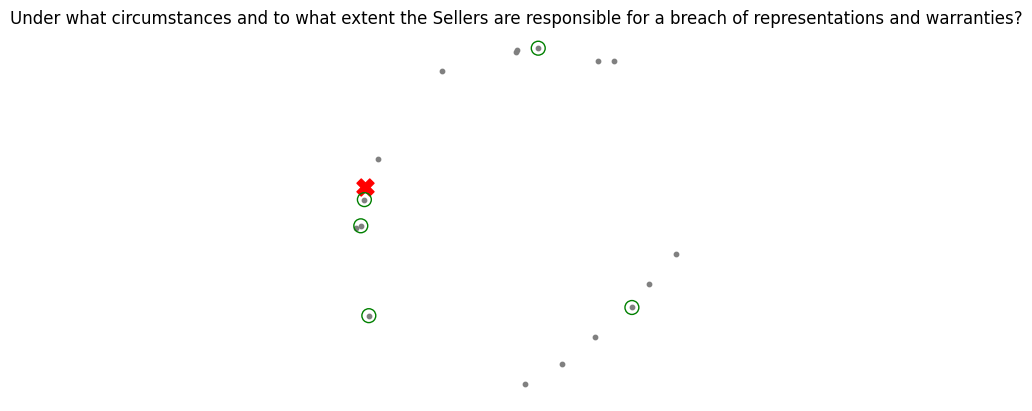

In [103]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [104]:
query = "How much is the escrow amount in value?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

this agreement may not be 

In [105]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The value of the escrow amount is not provided in the information given.


In [106]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

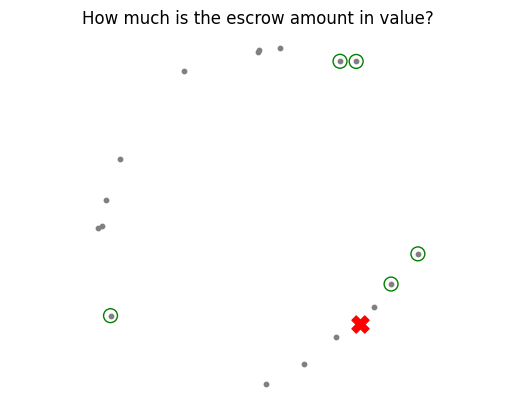

In [107]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [108]:
query = "How much is the escrow amount?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

- 3 - constitute salary pa

In [109]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The escrow amount is not mentioned in the provided information.


In [110]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

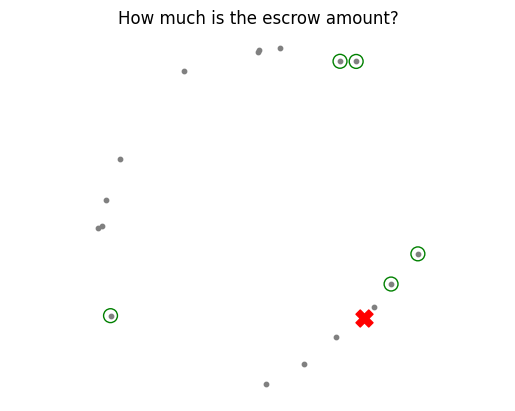

In [111]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [112]:
query = "Are there any conditions to the closing?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

5. non - compete : during the term of engagement with the company and for a period of 12 months thereafter, advisor shall not be involved, as an employee, owner, contractor or otherwise, in any business, which competes with the company ’ s business, and shall not solicit and / or hire any employee and / or service provider of the company, without the prior written consent of the company. 6. personnel : the advisor may provide the services only directly or through employees, contractors or agents ( “ personnel ” ), which were specifically approved by the company, and have committed in writ ing to confidentiality and ownership rights towards the advisor and / or the company, in a form restrictive enough to allow advisor to comply and enforce the commitments under this undertaking ( “ authorized personnel ” ). without limiting the foregoing, the advisor is liable hereunder for any breach of this undertaking by any advisor personne l.

- 2 - 4. term : the term of this agreement shall comme

In [113]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The conditions for closing include a non-compete clause, termination clauses, compensation details, specifics about authorized personnel, and jurisdiction rules.


In [114]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

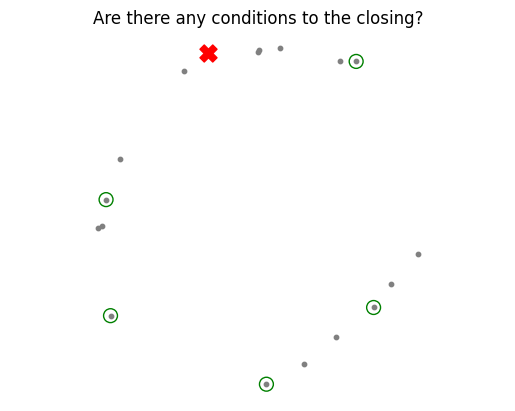

In [115]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')